In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../scripts")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
plt.rcParams["figure.figsize"] = (14,6)

In [5]:
obs = pd.read_csv("../data/obs-hunan.csv", parse_dates=["date"])
obs = obs.set_index("date")
obs = obs.drop(columns=["C"])
obs

,I,R,D
date,,,
2020-01-22,4,0,0
2020-01-23,6,0,0
2020-01-24,12,0,0
2020-01-25,20,0,0
2020-01-26,29,0,0
...,...,...,...
2020-06-05,0,1015,4
2020-06-06,0,1015,4
2020-06-07,0,1015,4


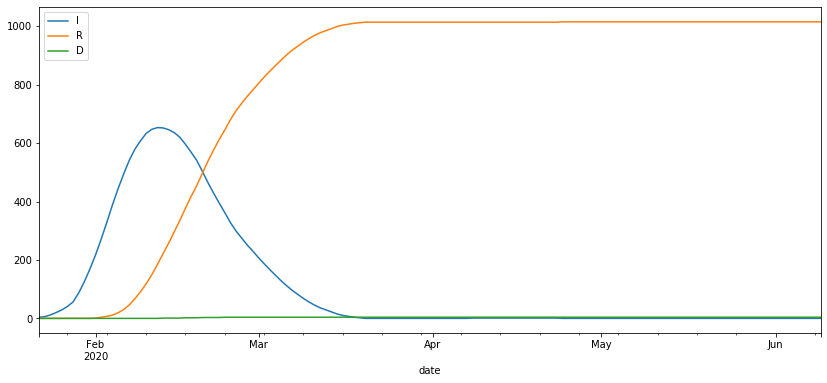

In [6]:
obs.plot()

In [7]:
def train_test_split(data, split, start=None, end=None):
    if start is None:
        start = data.index[0]
    if end is None:
        end = data.index[-1]
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    split = pd.to_datetime(split)
    one = pd.DateOffset(days=1)
    train = data[start:split-one].copy()
    test = data[split:end].copy()
    return train, test

In [8]:
#data_start = "2020-04-01"
data_split = "2020-04-01"
train, test = train_test_split(obs, split=data_split)

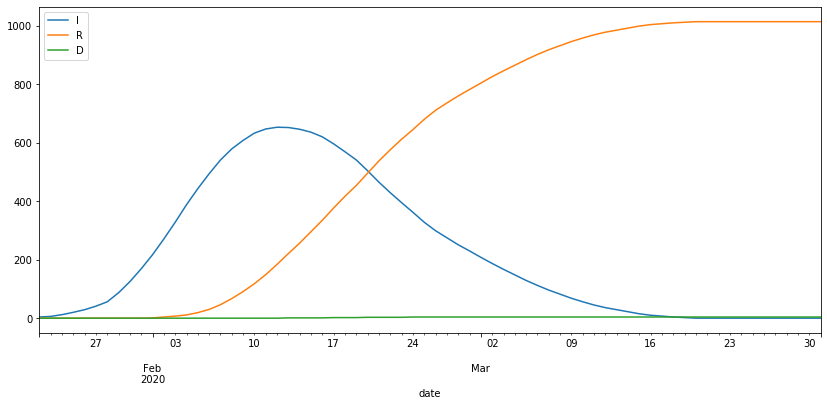

In [9]:
train.plot()

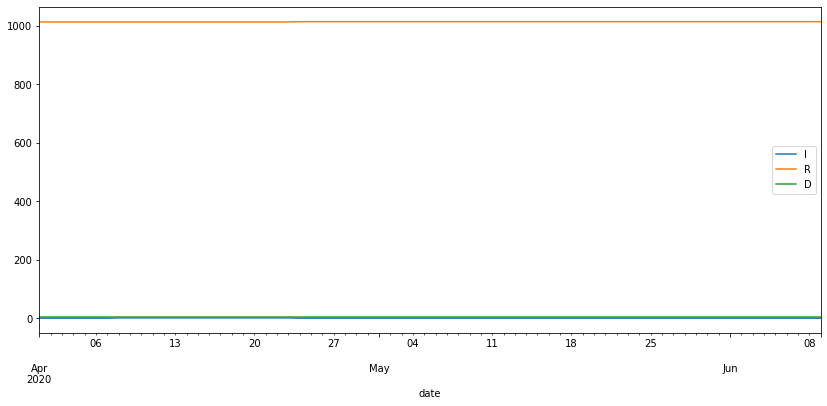

In [10]:
test.plot()

## SIR

In [11]:
from SEIR import SIR

In [12]:
init_I, init_R, init_D = train.head(1).to_numpy().flatten()

In [13]:
model = SIR(
    population=1e3, 
    init_infected=init_I, 
    init_recovered=init_R, 
    init_dead=init_D,
    r_transmission=0.5,
    r_recovery=1/17,
    r_mortality=0
)

In [14]:
model.fit(train, estimate=('r_transmission', "r_recovery", "r_mortality", "population"), 
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[4.24732696e-01, 6.25316499e-02, 7.05267878e-04, 1.08106163e+03],
       [4.24732695e-01, 6.25316414e-02, 7.05267358e-04, 1.08106166e+03],
       [4.24732719e-01, 6.25316374e-02, 7.05262220e-04, 1.08106153e+03],
       [4.24732707e-01, 6.25316431e-02, 7.05265817e-04, 1.08106153e+03],
       [4.24732725e-01, 6.25316480e-02, 7.05268855e-04, 1.08106161e+03]]), array([522124.27329159, 522124.27329162, 522124.27329166, 522124.27329167,
       522124.2732917 ]))
           fun: 522124.2732915925
       message: 'Optimization terminated successfully.'
          nfev: 259
           nit: 148
        status: 0
       success: True
             x: array([4.24732696e-01, 6.25316499e-02, 7.05267878e-04, 1.08106163e+03])

In [15]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start="2020-01-22", periods=T, freq="D")
res.index = idx

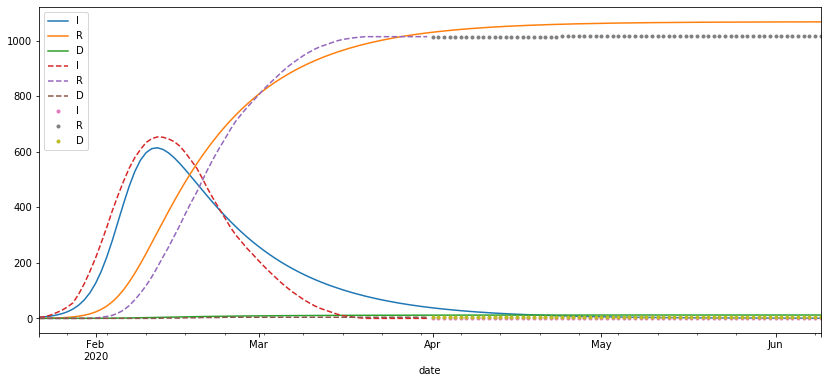

In [16]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")